In [1]:
#| hide
import sys
sys.path.append("/notebooks/katlas")
from nbdev.showdoc import *
%matplotlib inline

In [2]:
#| export
from katlas.core import Data
from katlas.train import *
from katlas.plot import *
from sklearn.model_selection import StratifiedGroupKFold

/usr/local/lib/python3.9/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

# Train ML model

> a collection of tools to train various ML model

In this file, we will show you how to train ML model using the features we extracted

## Prepare training file

amino acid

In [3]:
aa = Data.get_aa_feature()

In [4]:
aa.shape

(23, 73)

In [5]:
# reduce dimension
aa_pca = reduce_dim(aa,n_components=5)

# add annotation
aa_pca.columns = 'aa_' + aa_pca.columns

aa_pca = aa_pca.rename(columns = {'aa_aa':'aa'})

protein

In [6]:
prot = Data.get_esm_pca32()

In [7]:
prot.shape

(298, 33)

In [8]:
# add annotation
prot2 = prot.set_index('kinase')

prot2.columns = 'kinase_' + prot2.columns

prot = prot2.reset_index()

target with position info

In [9]:
target = Data.get_standard_unstack()

In [10]:
target.head()

,kinase,substrate,target,position,aa
0,AAK1,-5P,0.203681,-5,P
1,ACVR2A,-5P,-0.497906,-5,P
2,ACVR2B,-5P,-0.274530,-5,P
3,AKT1,-5P,-0.138624,-5,P
4,AKT2,-5P,-0.052269,-5,P


In [11]:
df = target.merge(prot).merge(aa_pca)

## Trainer

### ML models

We can use various ML models to train:
- Xgboost
- LightGBM
- Tablet
- Traditional ML: Regression, others

### XGB

In [12]:
show_doc(xgb_trainer)

---

### xgb_trainer

>      xgb_trainer (df, feature_col, target_col, test_index=None,
>                   xgb_params={'max_depth': 7, 'learning_rate': 0.001,
>                   'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric':
>                   'rmse', 'objective': 'reg:squarederror', 'tree_method':
>                   'gpu_hist', 'predictor': 'gpu_predictor', 'random_state':
>                   123}, model_file='xgb_model.bin', split_seed=123)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df |  |  |  |
| feature_col |  |  |  |
| target_col |  |  |  |
| test_index | NoneType | None |  |
| xgb_params | dict | {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123} |  |
| model_file | str | xgb_model.bin |  |
| split_seed | int | 123 | seed of random split |

Specify the feature column and target column

In [13]:
feat_col = ['position'] + df.columns[5:].tolist()

In [14]:
target_col = 'target'

If test_index is not specified, then it will randomly choose some samples as test set

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47203, 38) (47203,) (11801, 38) (11801,)
Int64Index([13407, 22203, 19019, 10720, 20479, 53592, 36083, 23618, 50335,
            42226,
            ...
            12796, 52753, 45368, 35051,  8088,   858, 13926, 22387, 30184,
            53047],
           dtype='int64', length=11801)
[0]	train-rmse:1.12026	valid-rmse:1.08382
[100]	train-rmse:1.07567	valid-rmse:1.04260
[200]	train-rmse:1.03709	valid-rmse:1.00732
[300]	train-rmse:1.00377	valid-rmse:0.97724
[400]	train-rmse:0.97487	valid-rmse:0.95146
[500]	train-rmse:0.94992	valid-rmse:0.92948
[600]	train-rmse:0.92802	valid-rmse:0.91040
[700]	train-rmse:0.90890	valid-rmse:0.89396
[800]	train-rmse:0.89220	valid-rmse:0.87985
[900]	train-rmse:0.87738	valid-rmse:0.86752
[1000]	train-rmse:0.86434	valid-rmse:0.85677

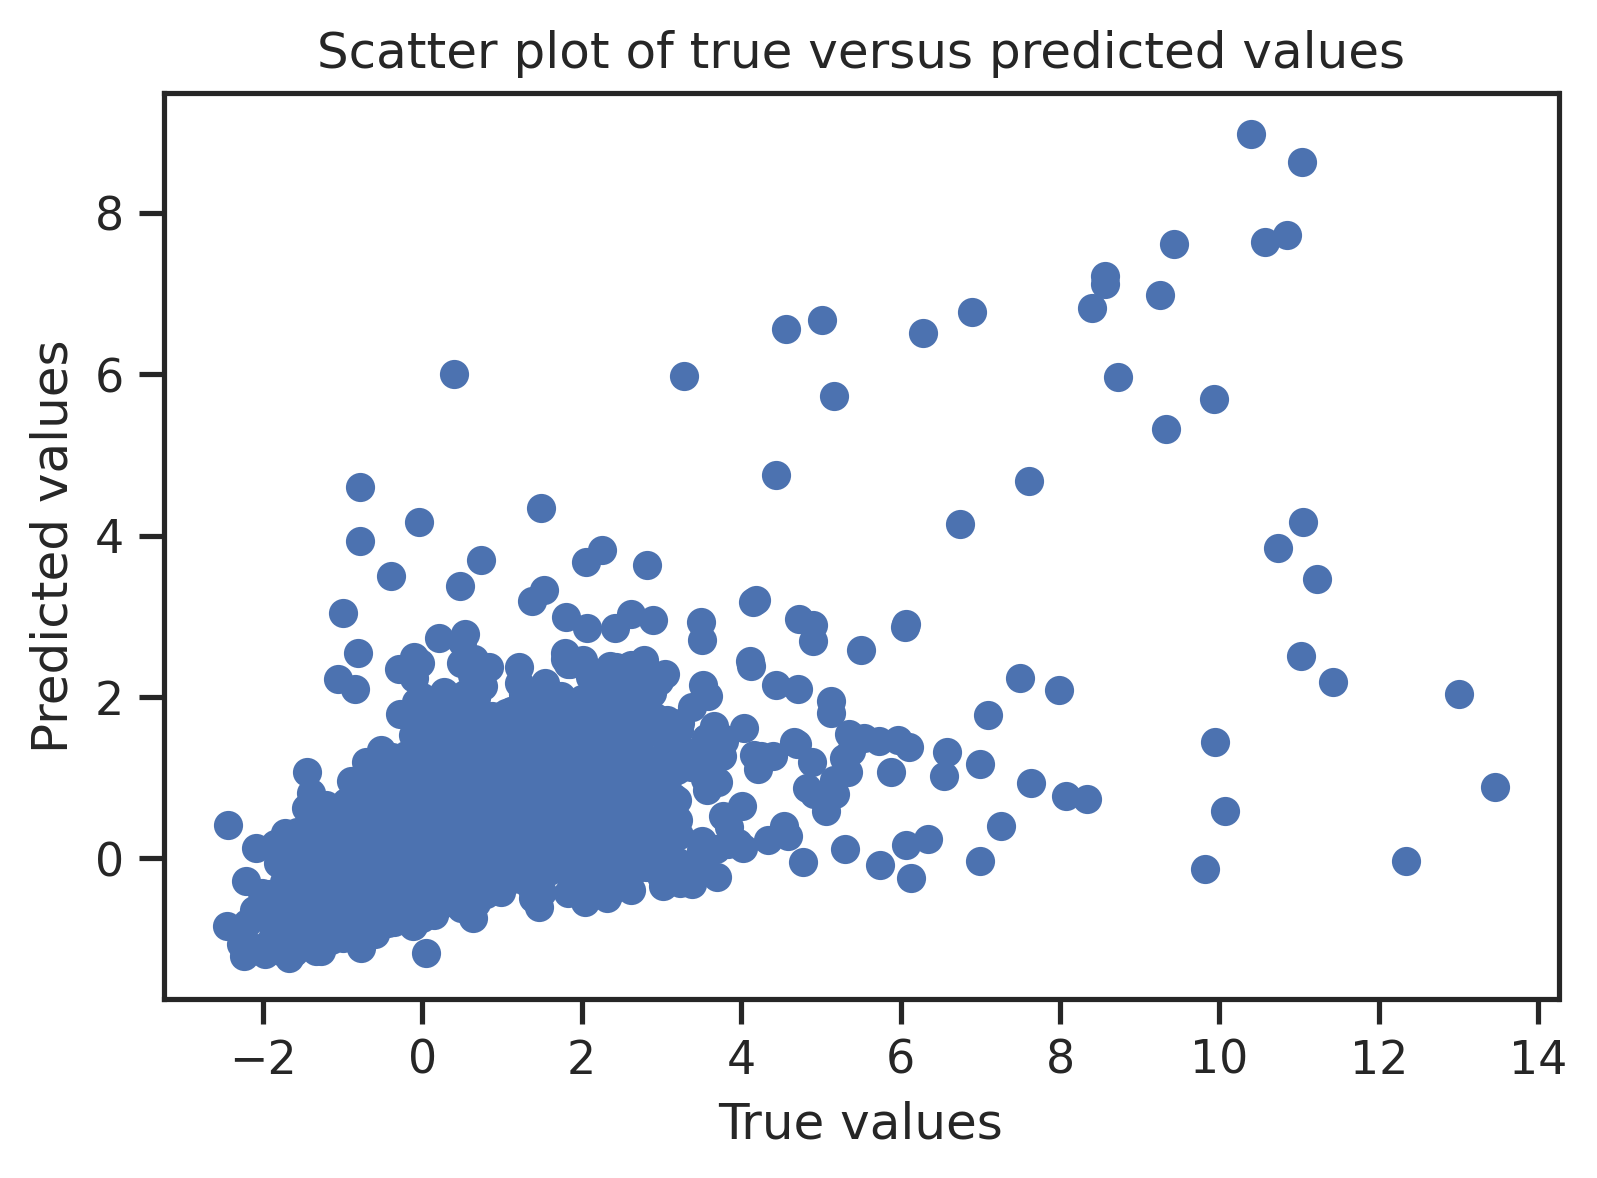

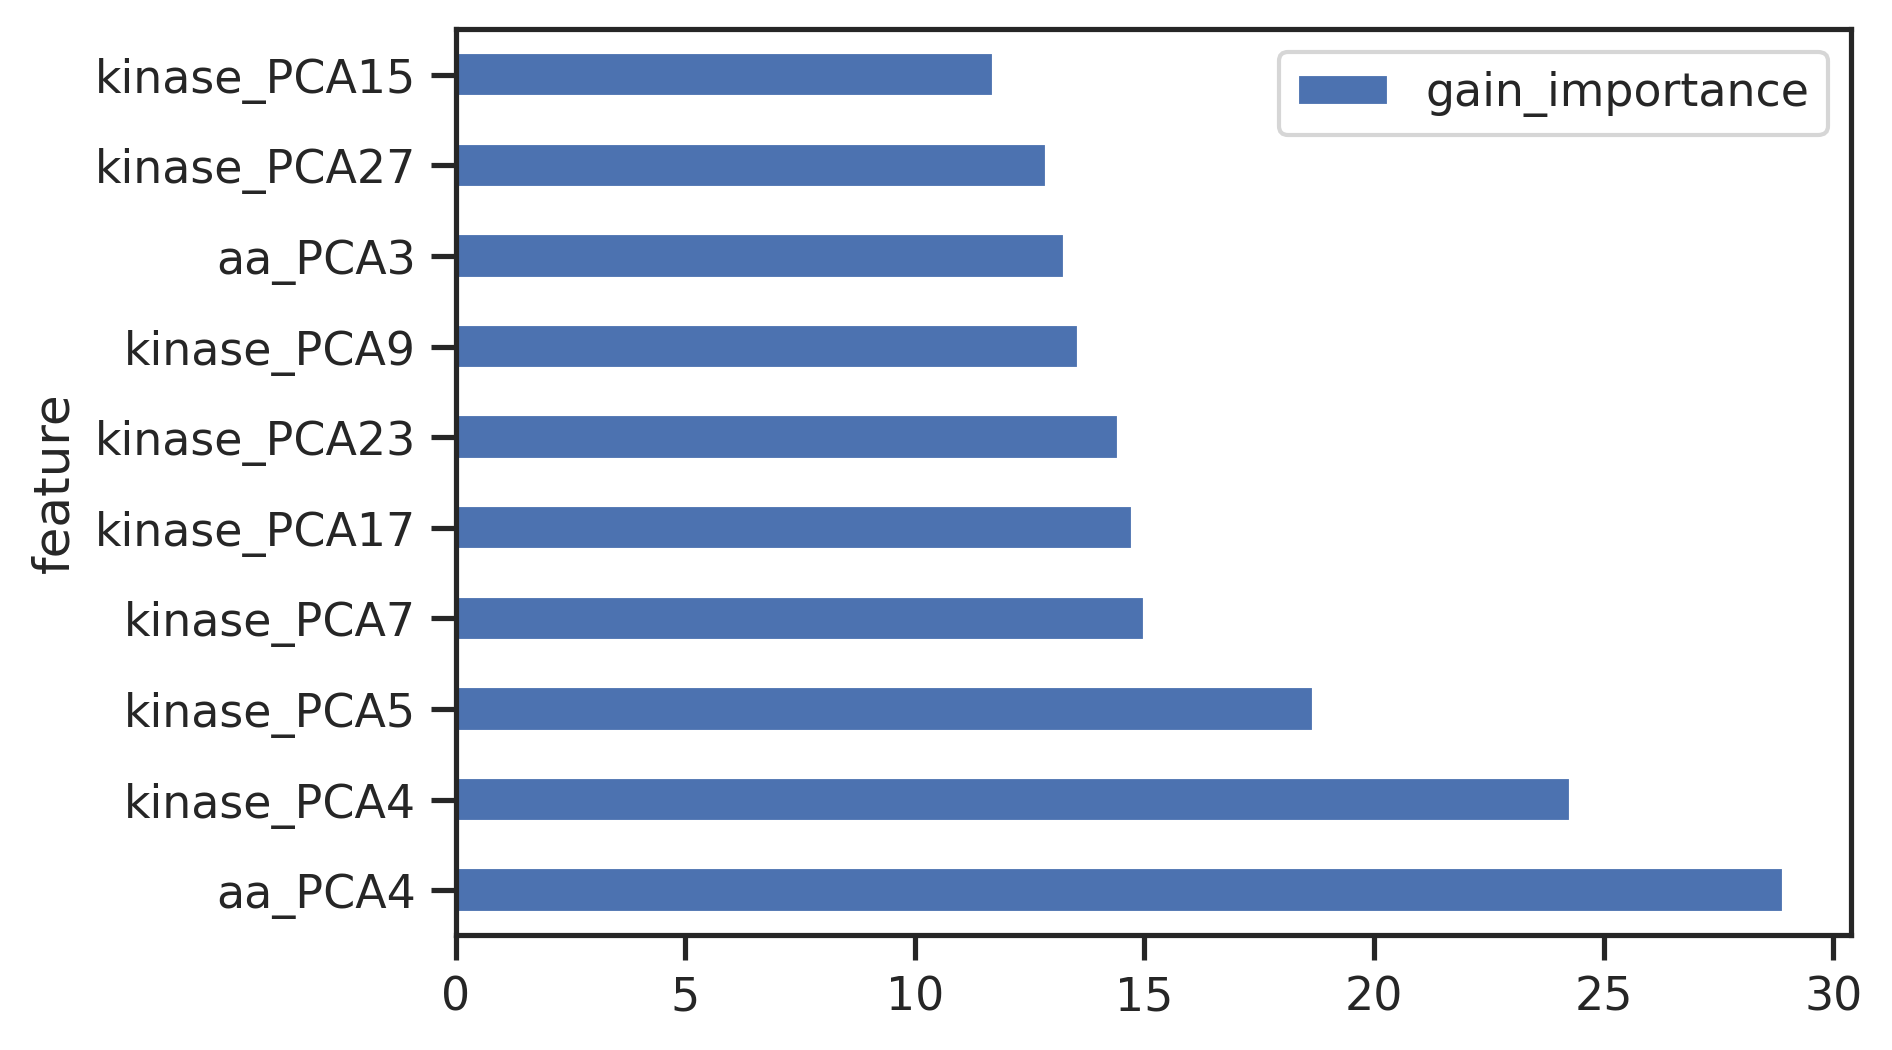

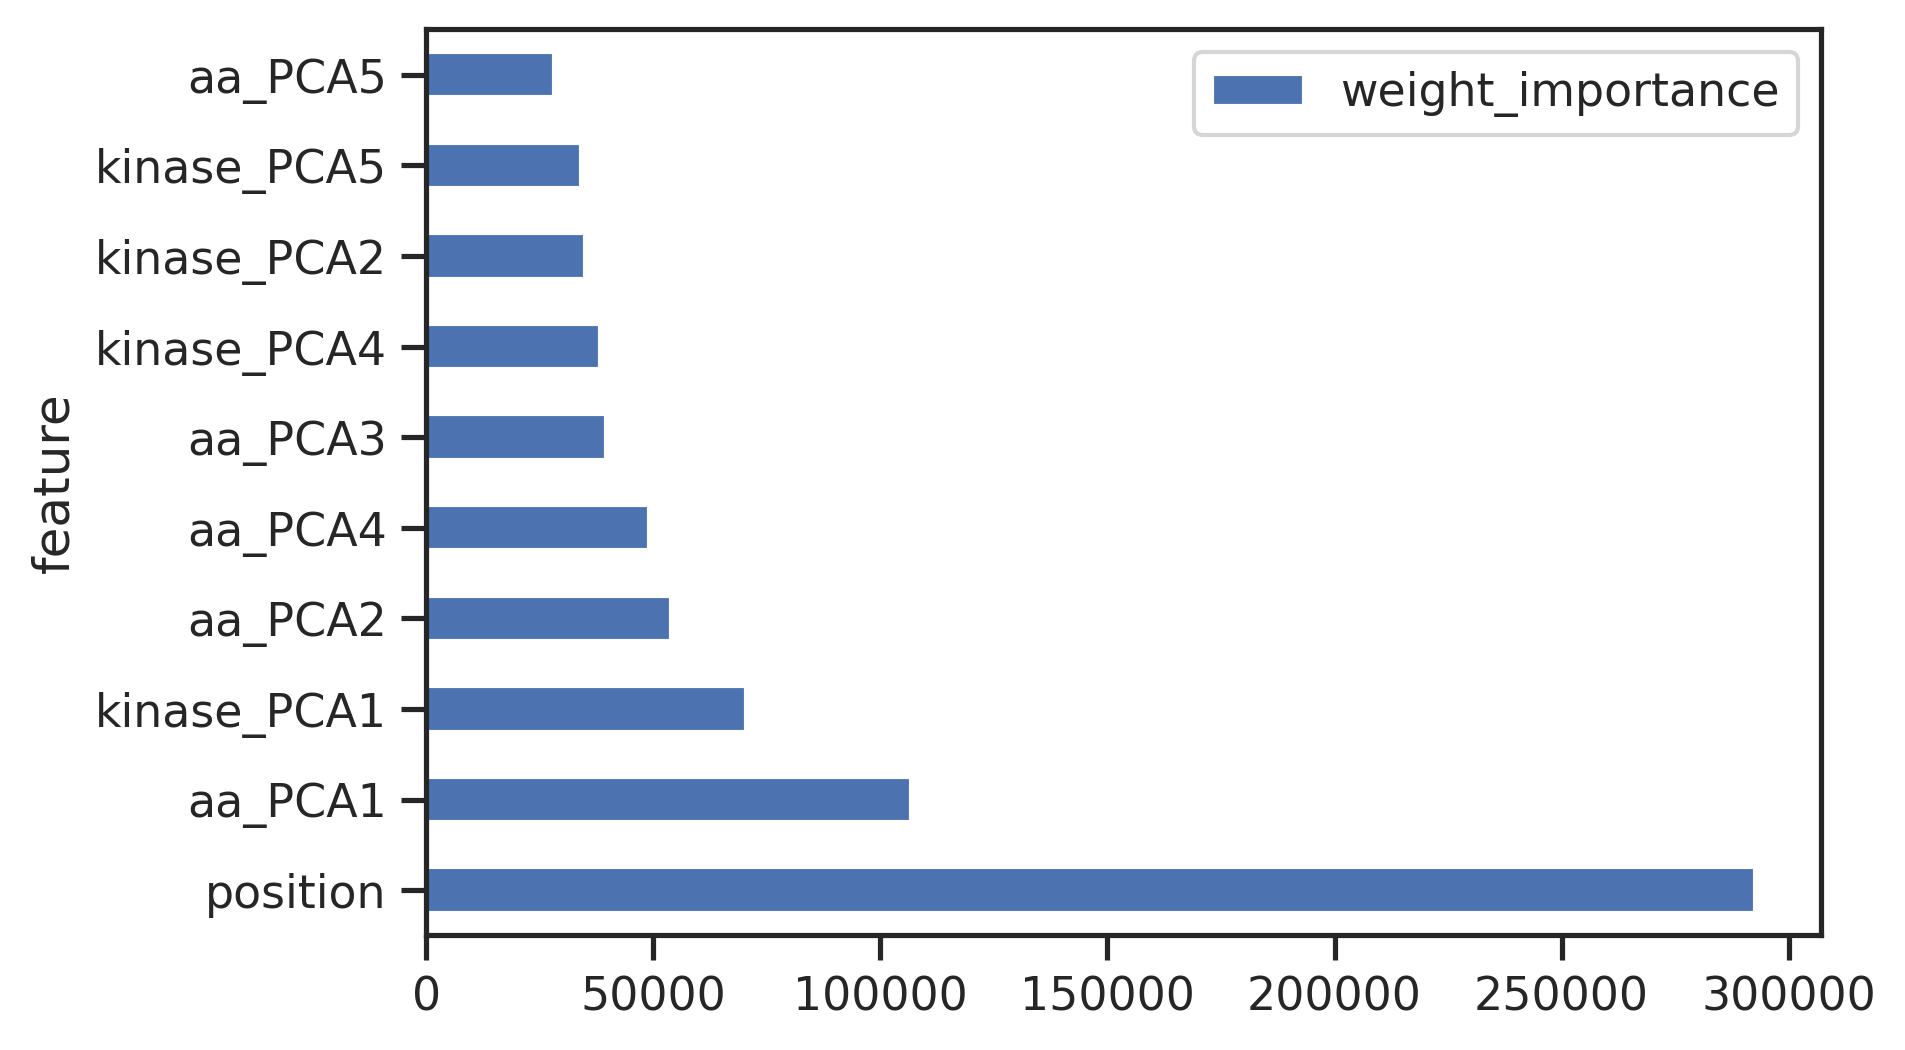

In [15]:
pred, gain, weight = xgb_trainer(df, feat_col, target_col,model_file = 'model/xgb.bin')

### Split method: StratifiedGroupKfold

We will use StratifiedGroupKFold to split the training and valid set: we group each point by kinase, and then stratify the kinase by their category. This split method ensures that the model can see different patterns of substrate specificity

In [20]:
# prepare the dataframe for split
kinase_info = Data.get_kinase_info()

kinase_info = kinase_info[['kinase','Family','category','category_big']]

df2 = df[['kinase']].merge(kinase_info)

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47124, 38) (47124,) (11880, 38) (11880,)
Int64Index([  396,   397,   398,   399,   400,   401,   402,   403,   404,
              405,
            ...
            58004, 58005, 58006, 58007, 58008, 58009, 58010, 58011, 58012,
            58013],
           dtype='int64', length=11880)
[0]	train-rmse:1.09019	valid-rmse:1.19967
[100]	train-rmse:1.04661	valid-rmse:1.16338
[200]	train-rmse:1.00888	valid-rmse:1.13234
[300]	train-rmse:0.97609	valid-rmse:1.10599
[400]	train-rmse:0.94770	valid-rmse:1.08364
[500]	train-rmse:0.92299	valid-rmse:1.06462
[600]	train-rmse:0.90156	valid-rmse:1.04776
[700]	train-rmse:0.88273	valid-rmse:1.03328
[800]	train-rmse:0.86620	valid-rmse:1.02090
[900]	train-rmse:0.85169	valid-rmse:1.01018
[1000]	train-rmse:0.83891	valid-rmse:1.00068

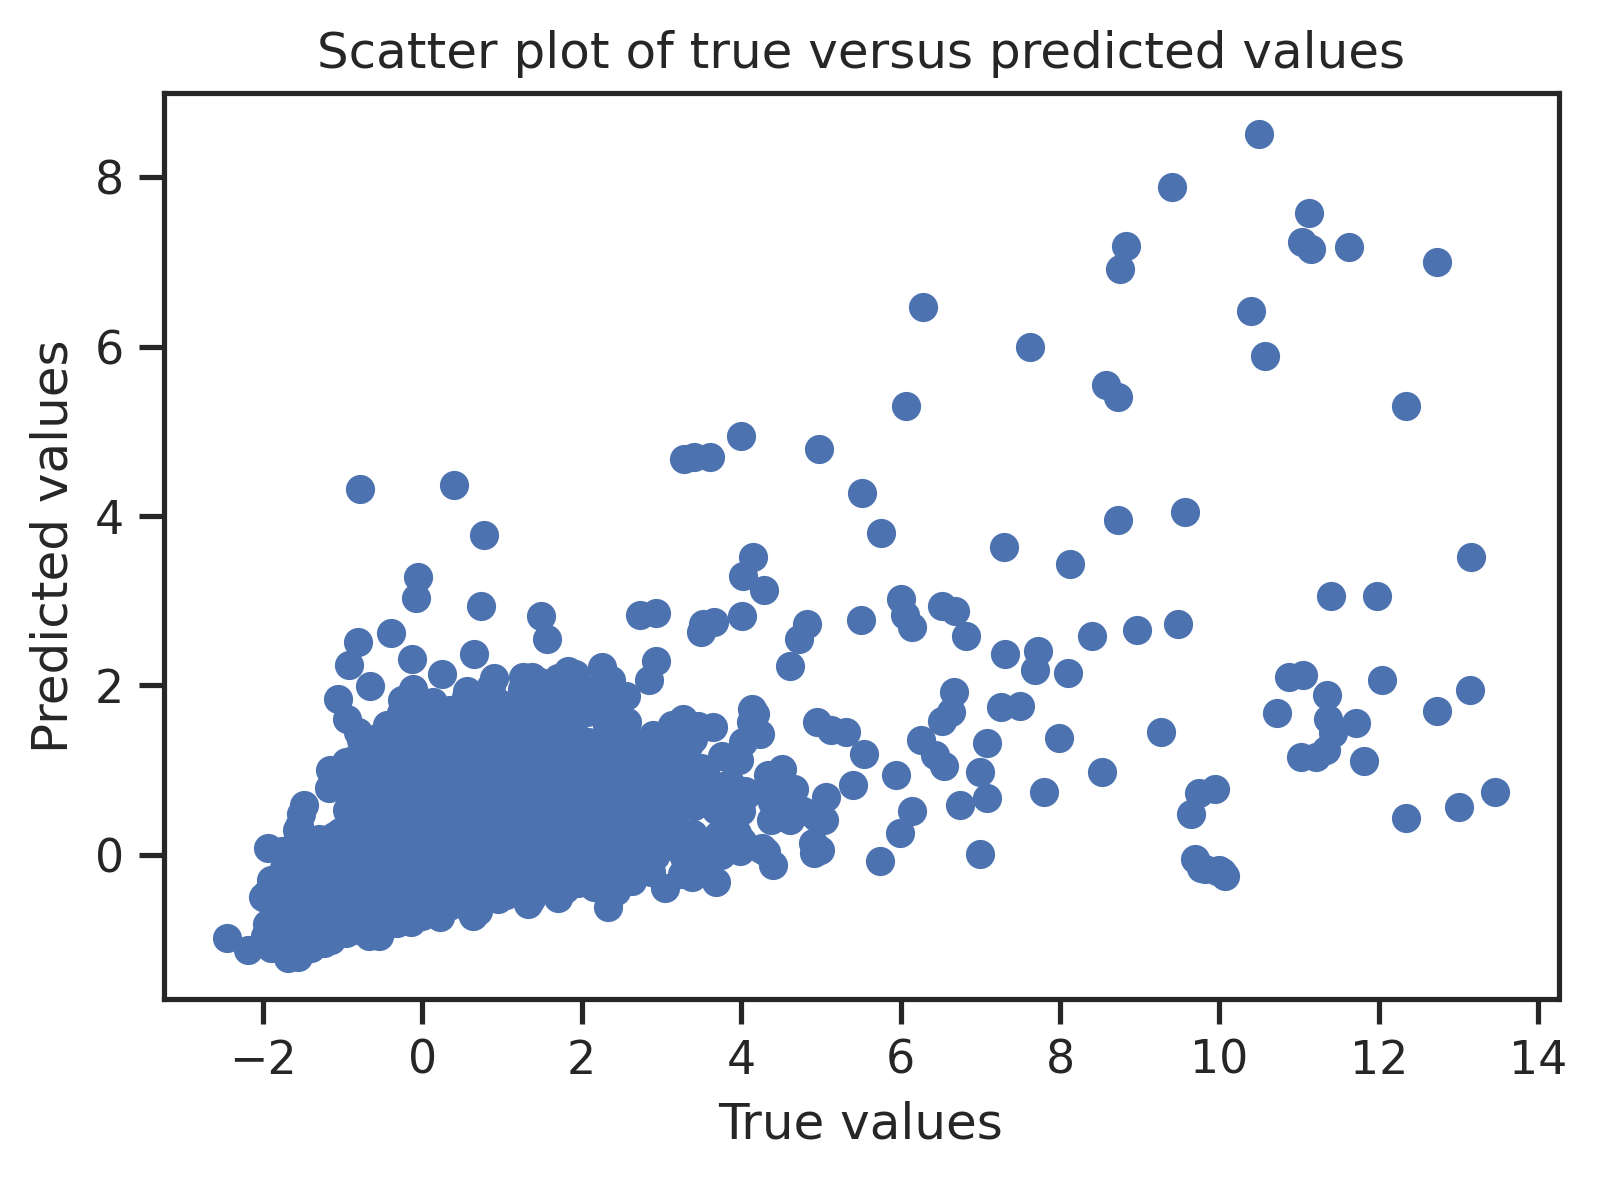

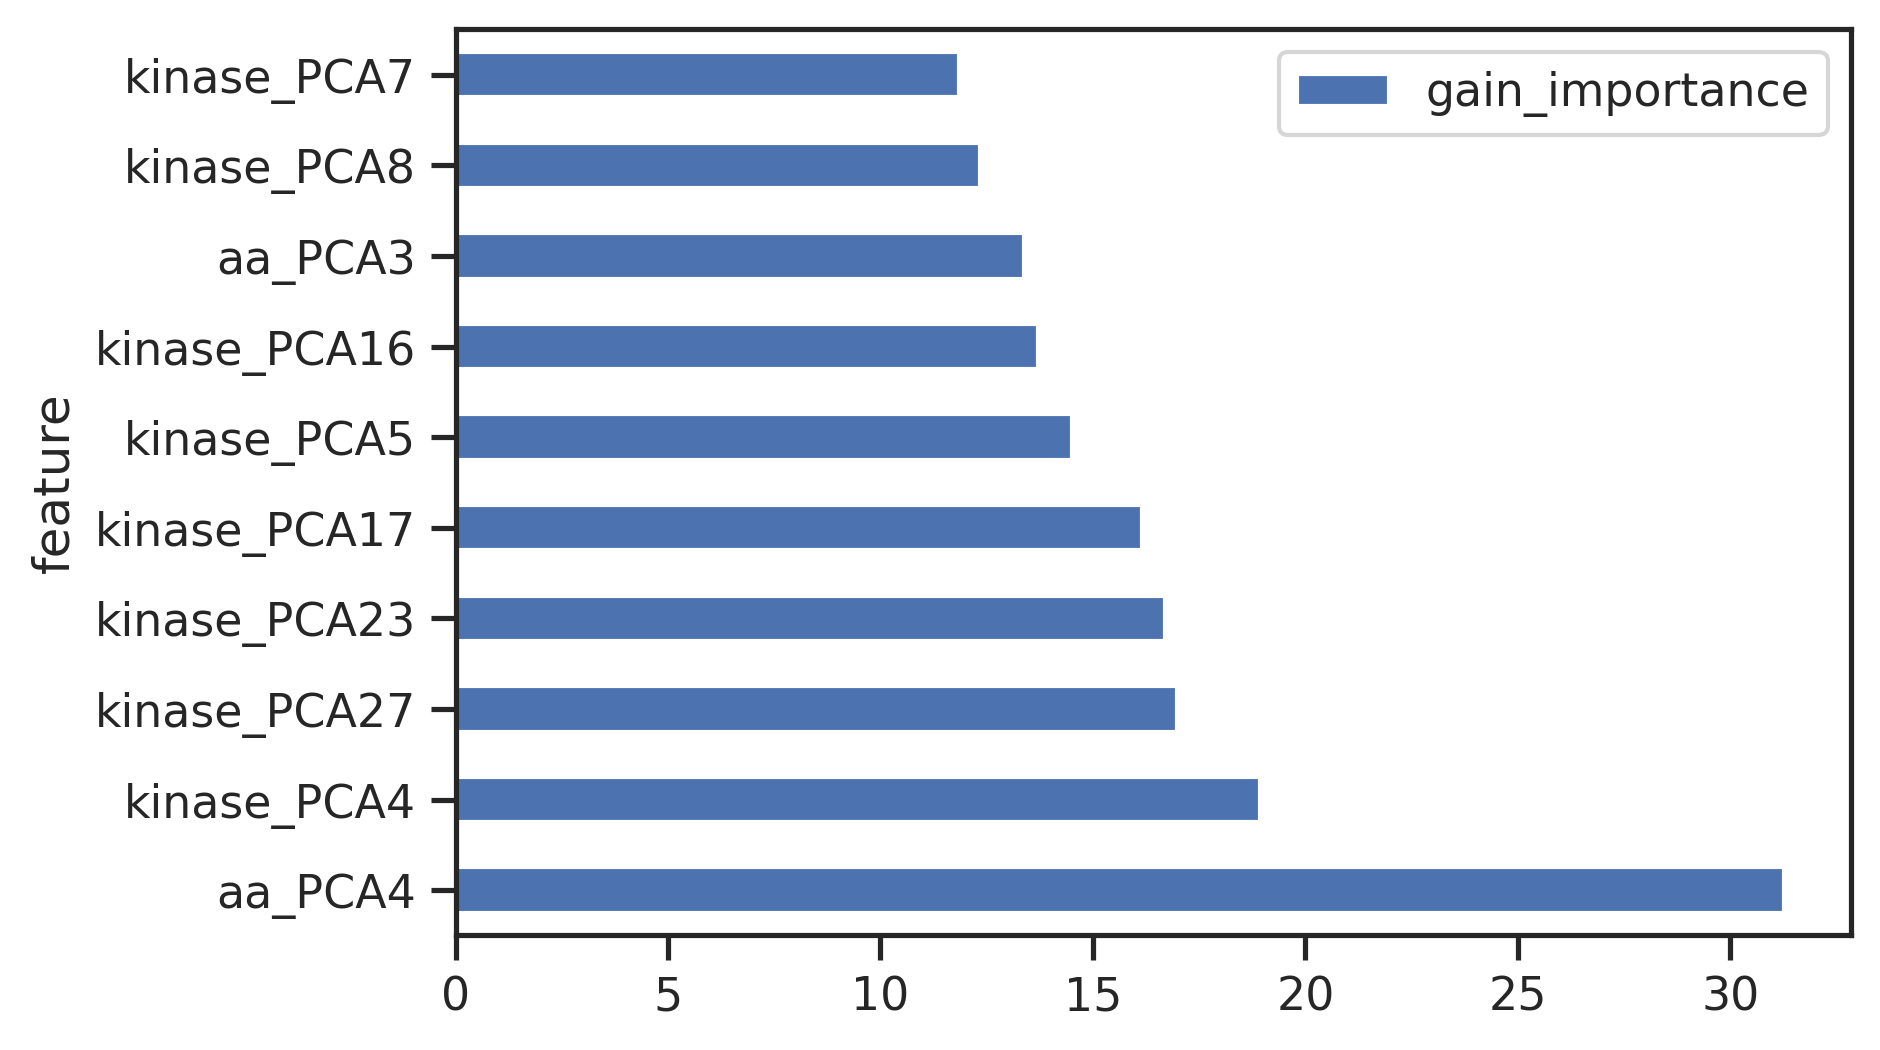

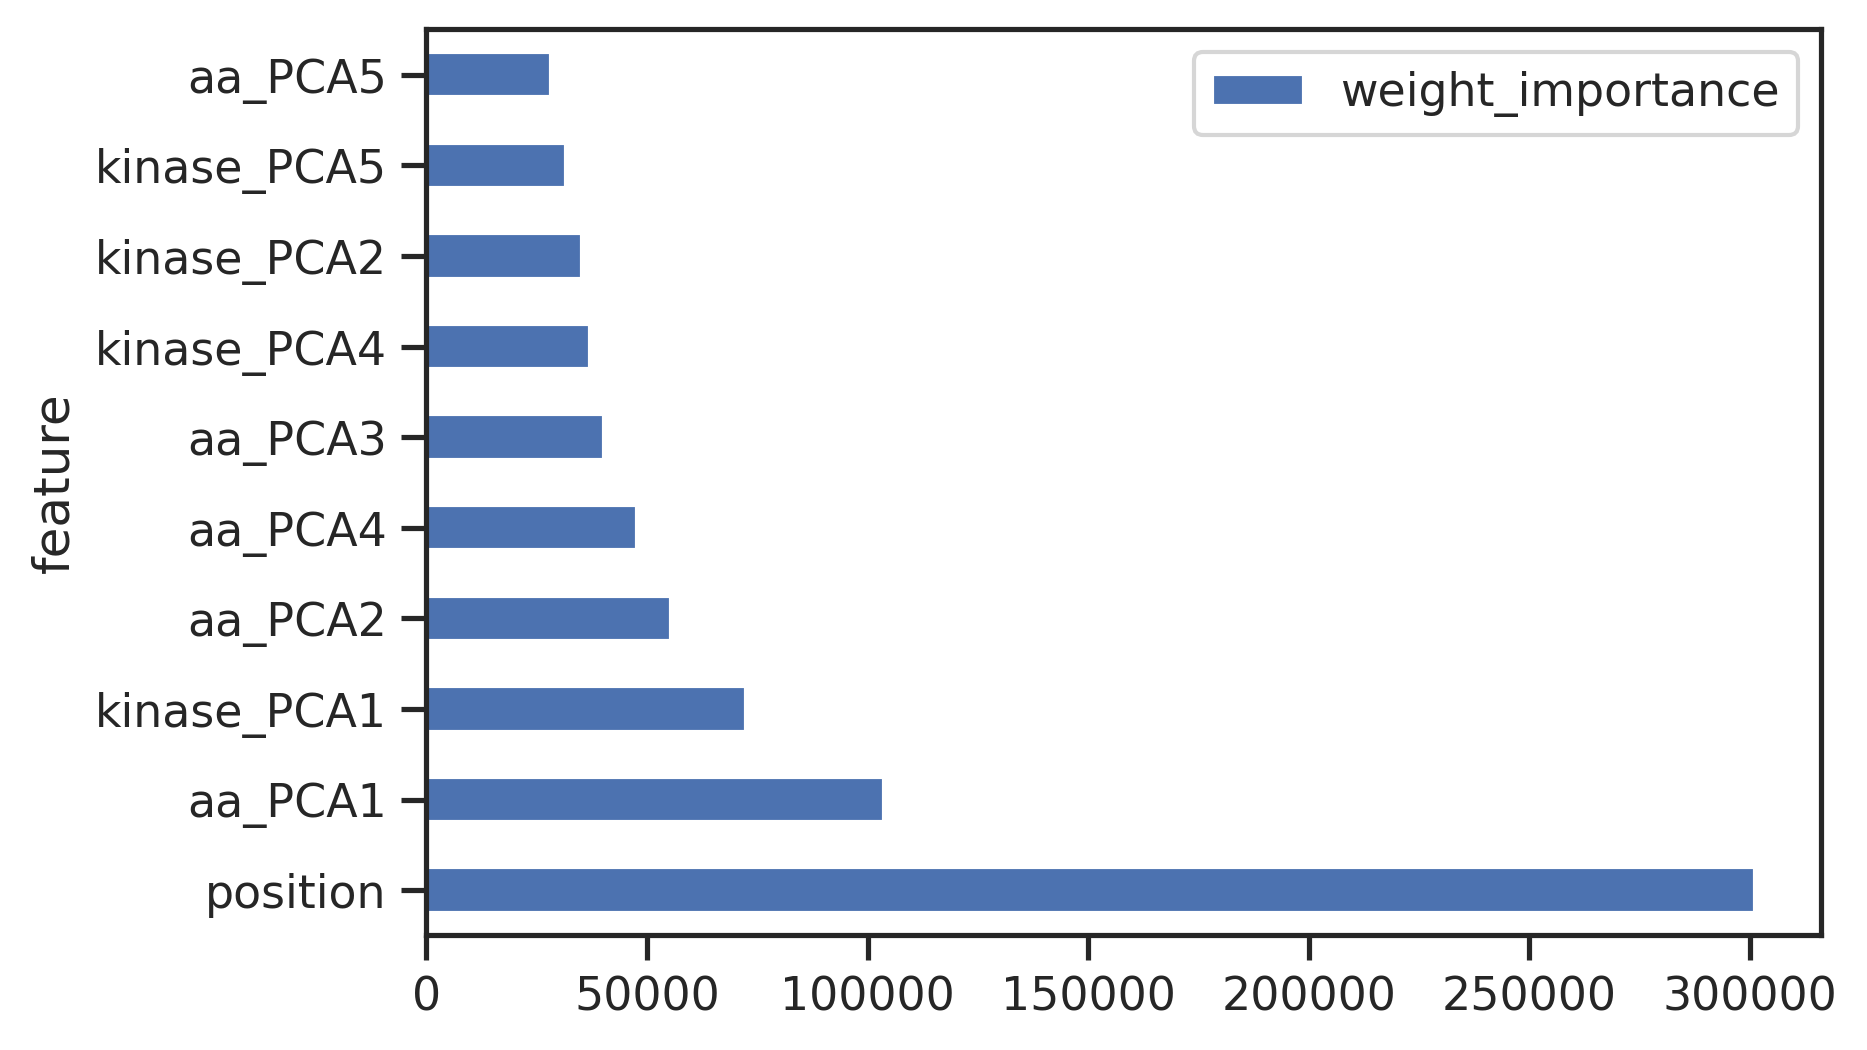

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47124, 38) (47124,) (11880, 38) (11880,)
Int64Index([  990,   991,   992,   993,   994,   995,   996,   997,   998,
              999,
            ...
            58796, 58797, 58798, 58799, 58800, 58801, 58802, 58803, 58804,
            58805],
           dtype='int64', length=11880)
[0]	train-rmse:1.11201	valid-rmse:1.11728
[100]	train-rmse:1.06738	valid-rmse:1.08122
[200]	train-rmse:1.02876	valid-rmse:1.05086
[300]	train-rmse:0.99503	valid-rmse:1.02492
[400]	train-rmse:0.96589	valid-rmse:1.00330
[500]	train-rmse:0.94033	valid-rmse:0.98480
[600]	train-rmse:0.91798	valid-rmse:0.96924
[700]	train-rmse:0.89844	valid-rmse:0.95625
[800]	train-rmse:0.88146	valid-rmse:0.94532
[900]	train-rmse:0.86634	valid-rmse:0.93594
[1000]	train-rmse:0.85298	valid-rmse:0.92796

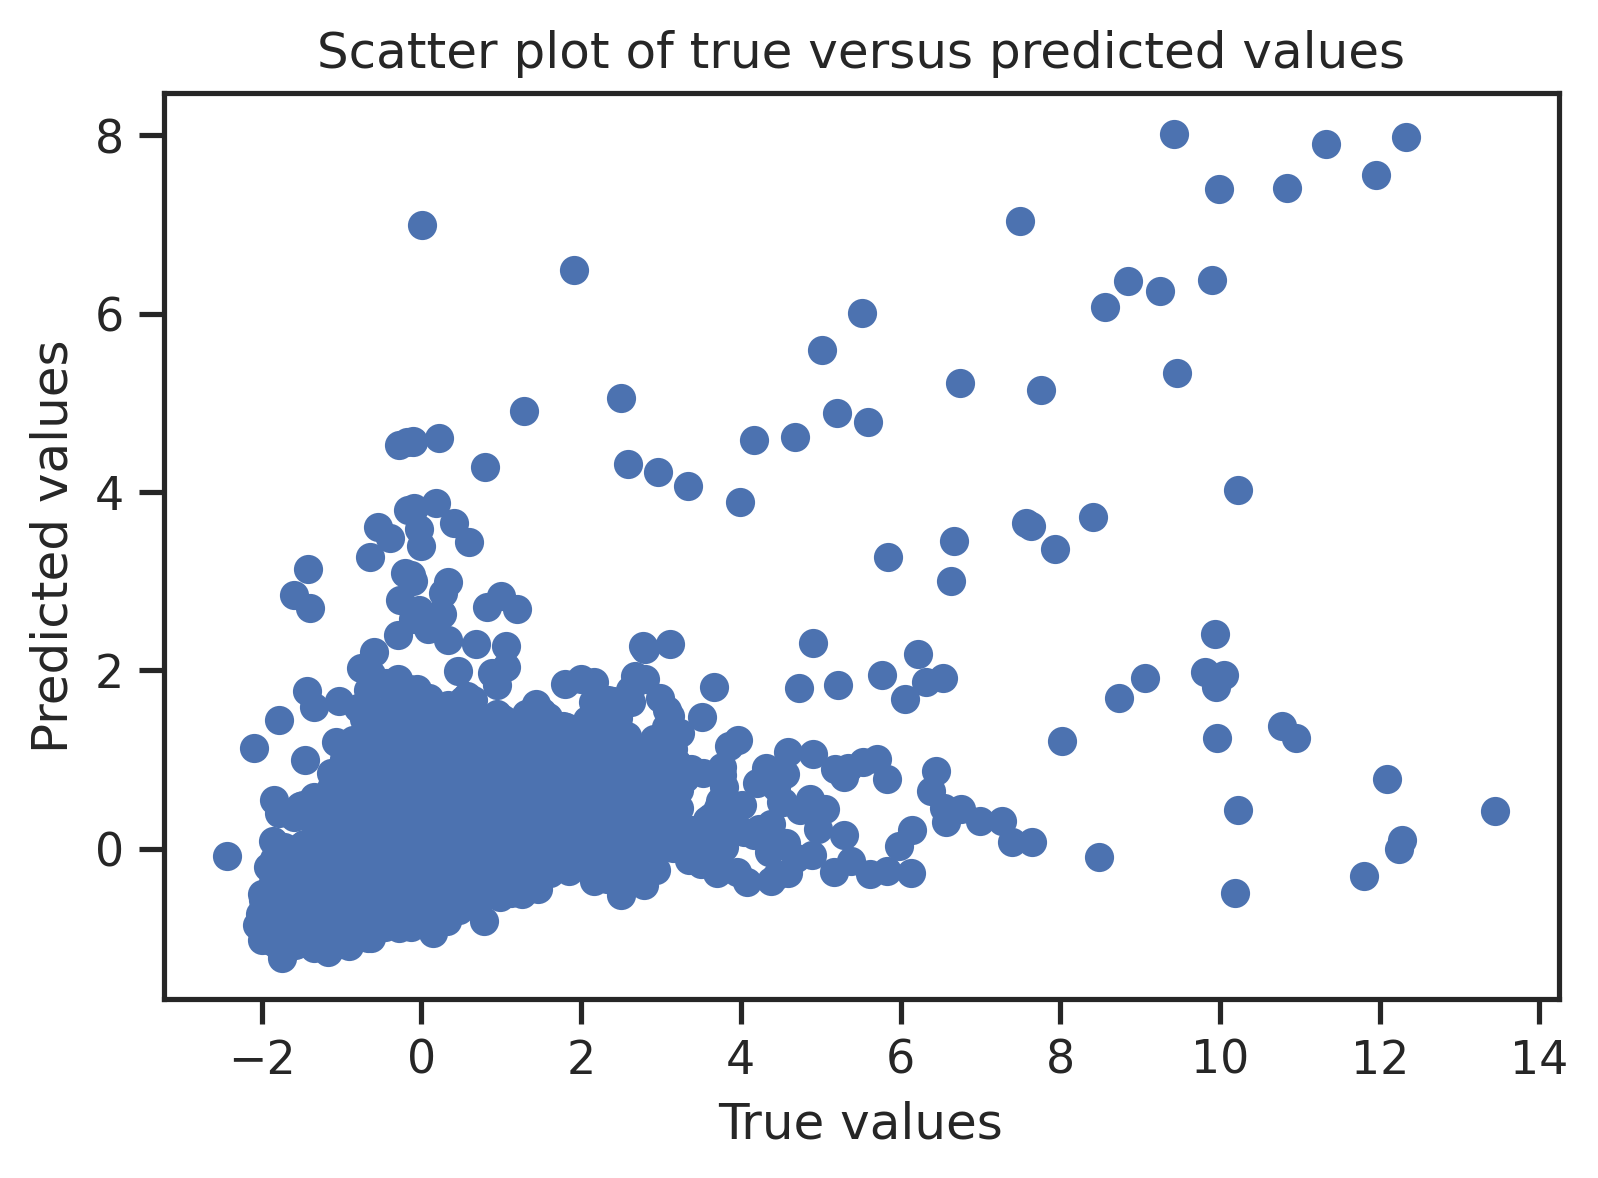

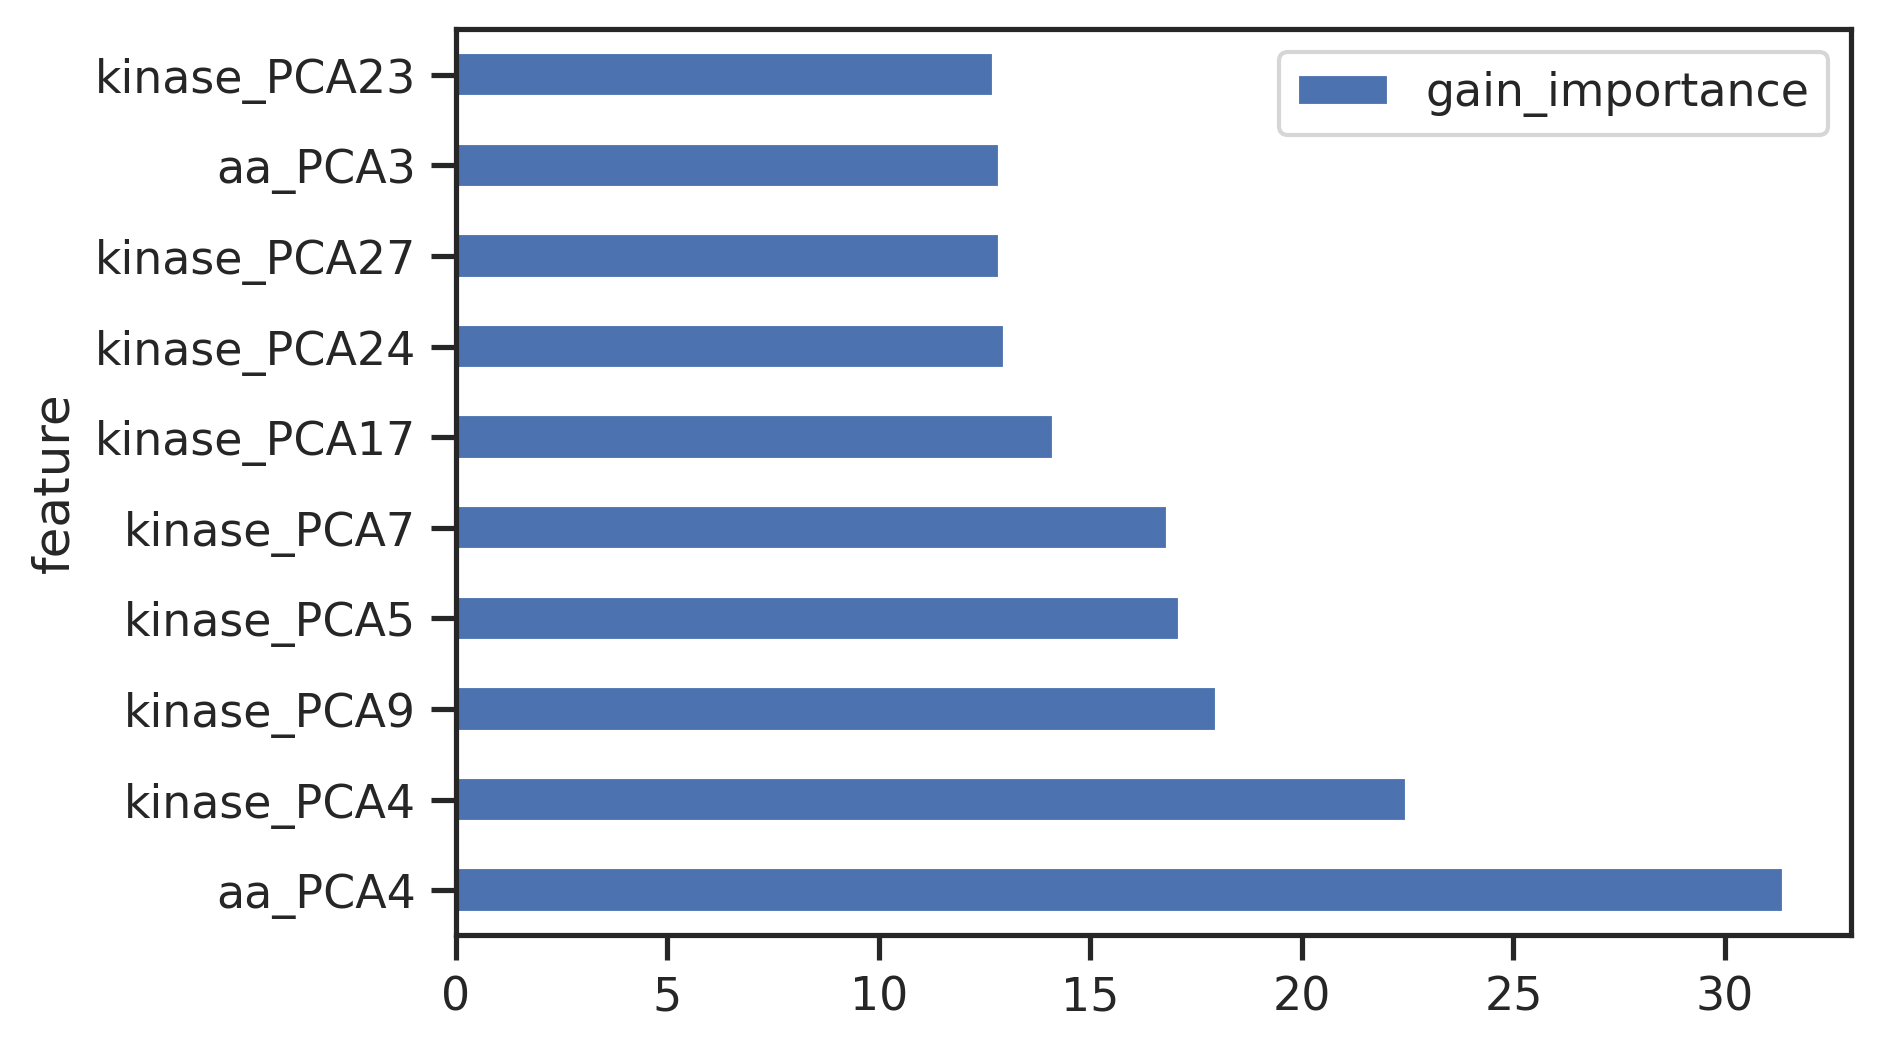

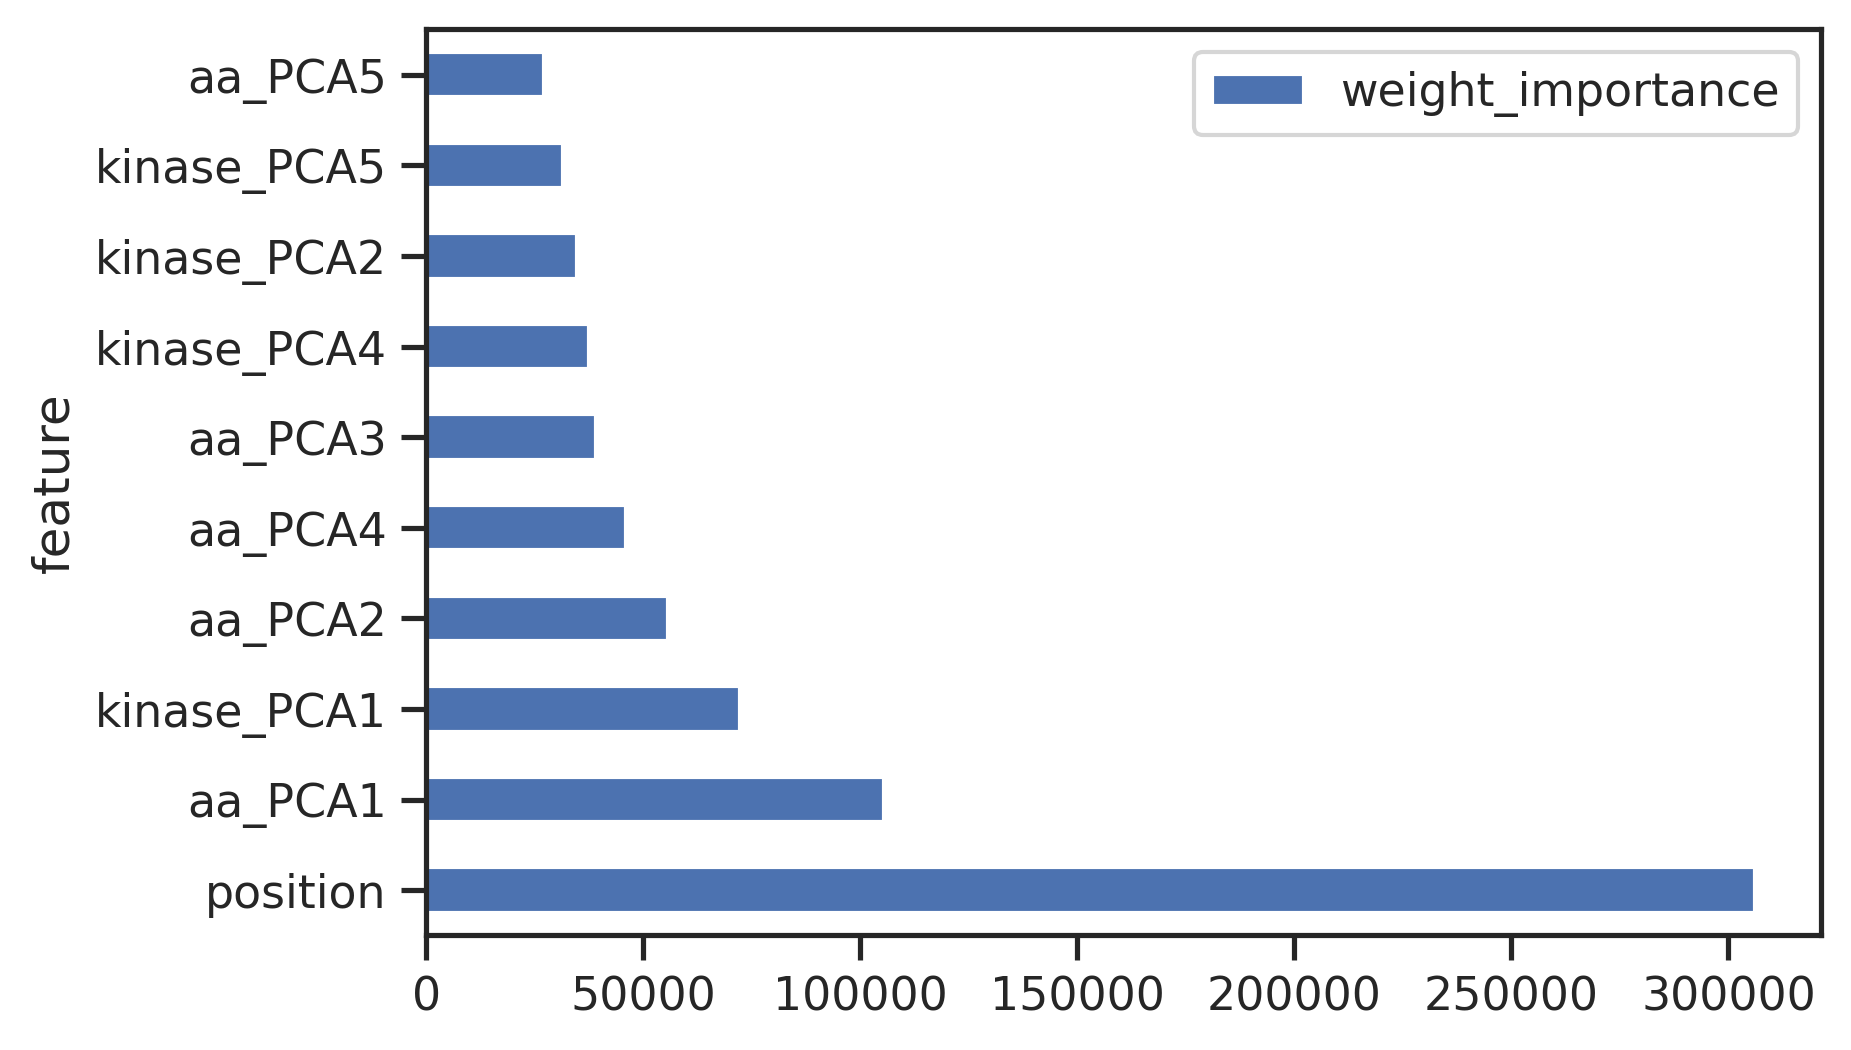

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47322, 38) (47322,) (11682, 38) (11682,)
Int64Index([ 1386,  1387,  1388,  1389,  1390,  1391,  1392,  1393,  1394,
             1395,
            ...
            58598, 58599, 58600, 58601, 58602, 58603, 58604, 58605, 58606,
            58607],
           dtype='int64', length=11682)
[0]	train-rmse:1.13284	valid-rmse:1.02907
[100]	train-rmse:1.08782	valid-rmse:0.99345
[200]	train-rmse:1.04870	valid-rmse:0.96359
[300]	train-rmse:1.01472	valid-rmse:0.93869
[400]	train-rmse:0.98519	valid-rmse:0.91751
[500]	train-rmse:0.95955	valid-rmse:0.90001
[600]	train-rmse:0.93734	valid-rmse:0.88530
[700]	train-rmse:0.91796	valid-rmse:0.87295
[800]	train-rmse:0.90102	valid-rmse:0.86209
[900]	train-rmse:0.88581	valid-rmse:0.85261
[1000]	train-rmse:0.87217	valid-rmse:0.84397

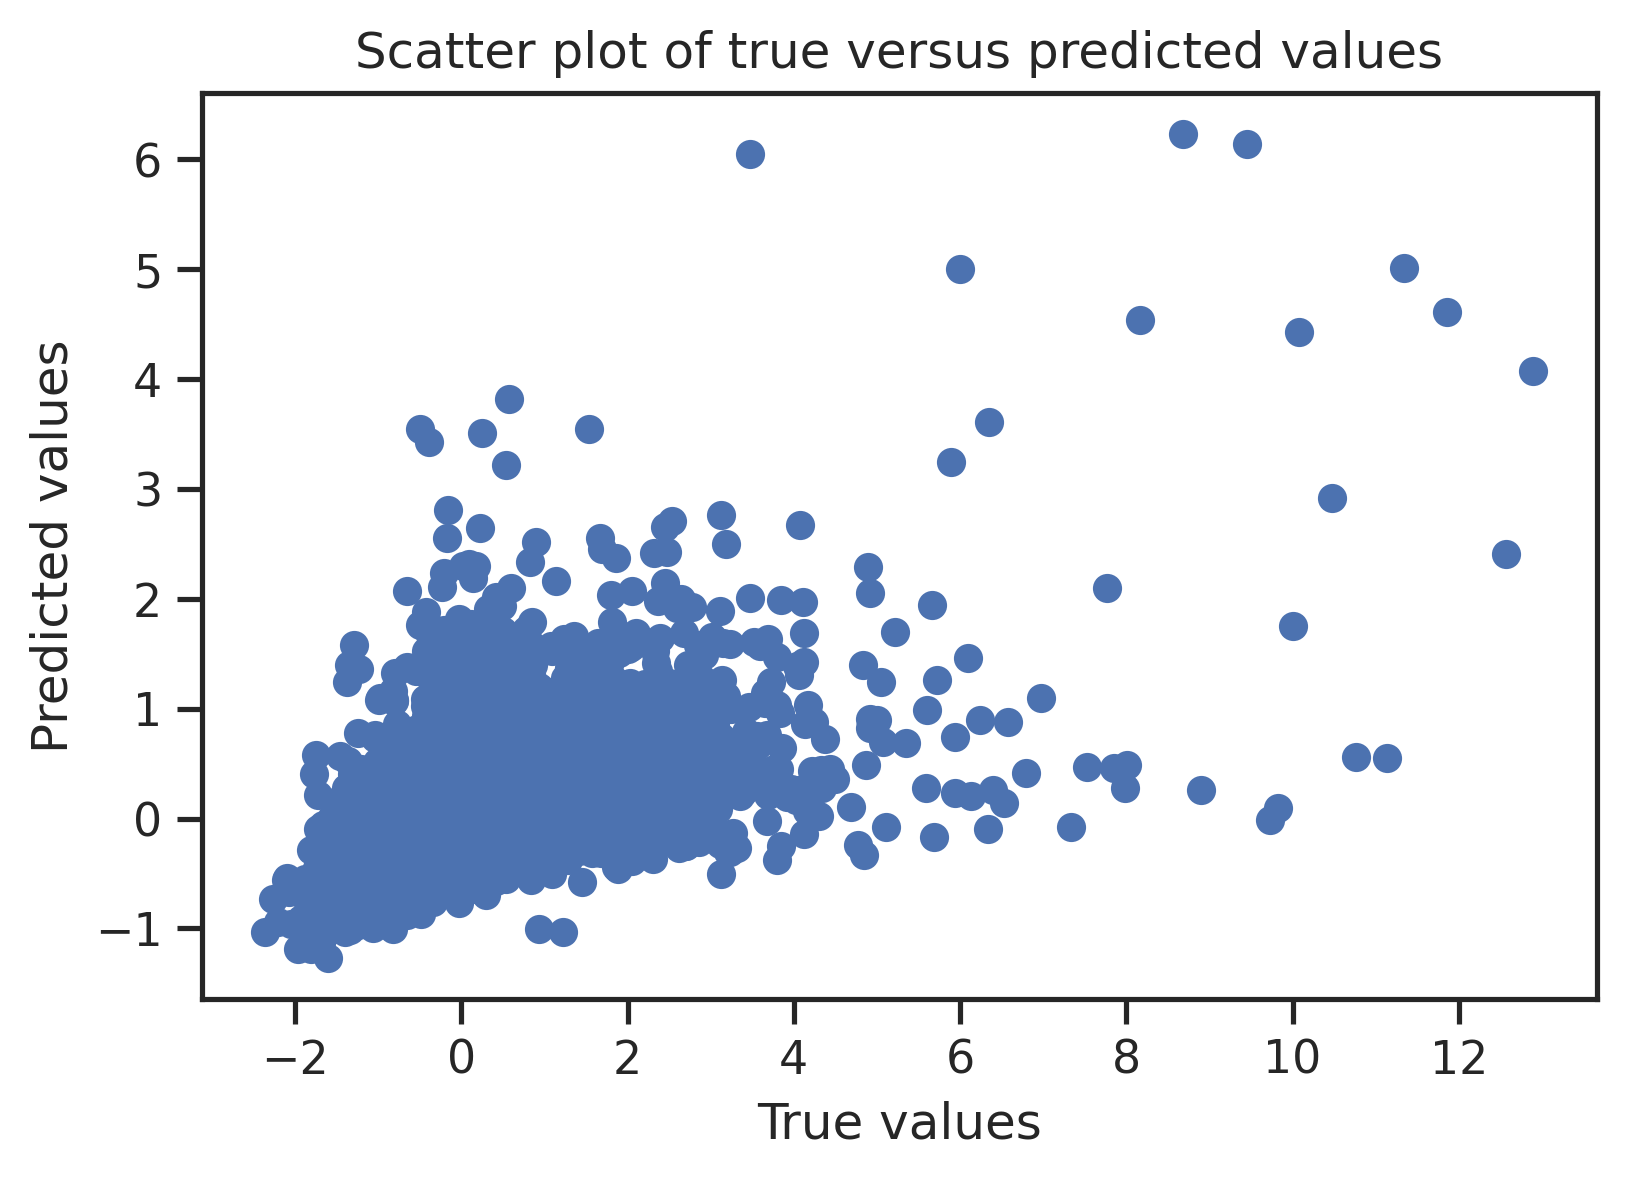

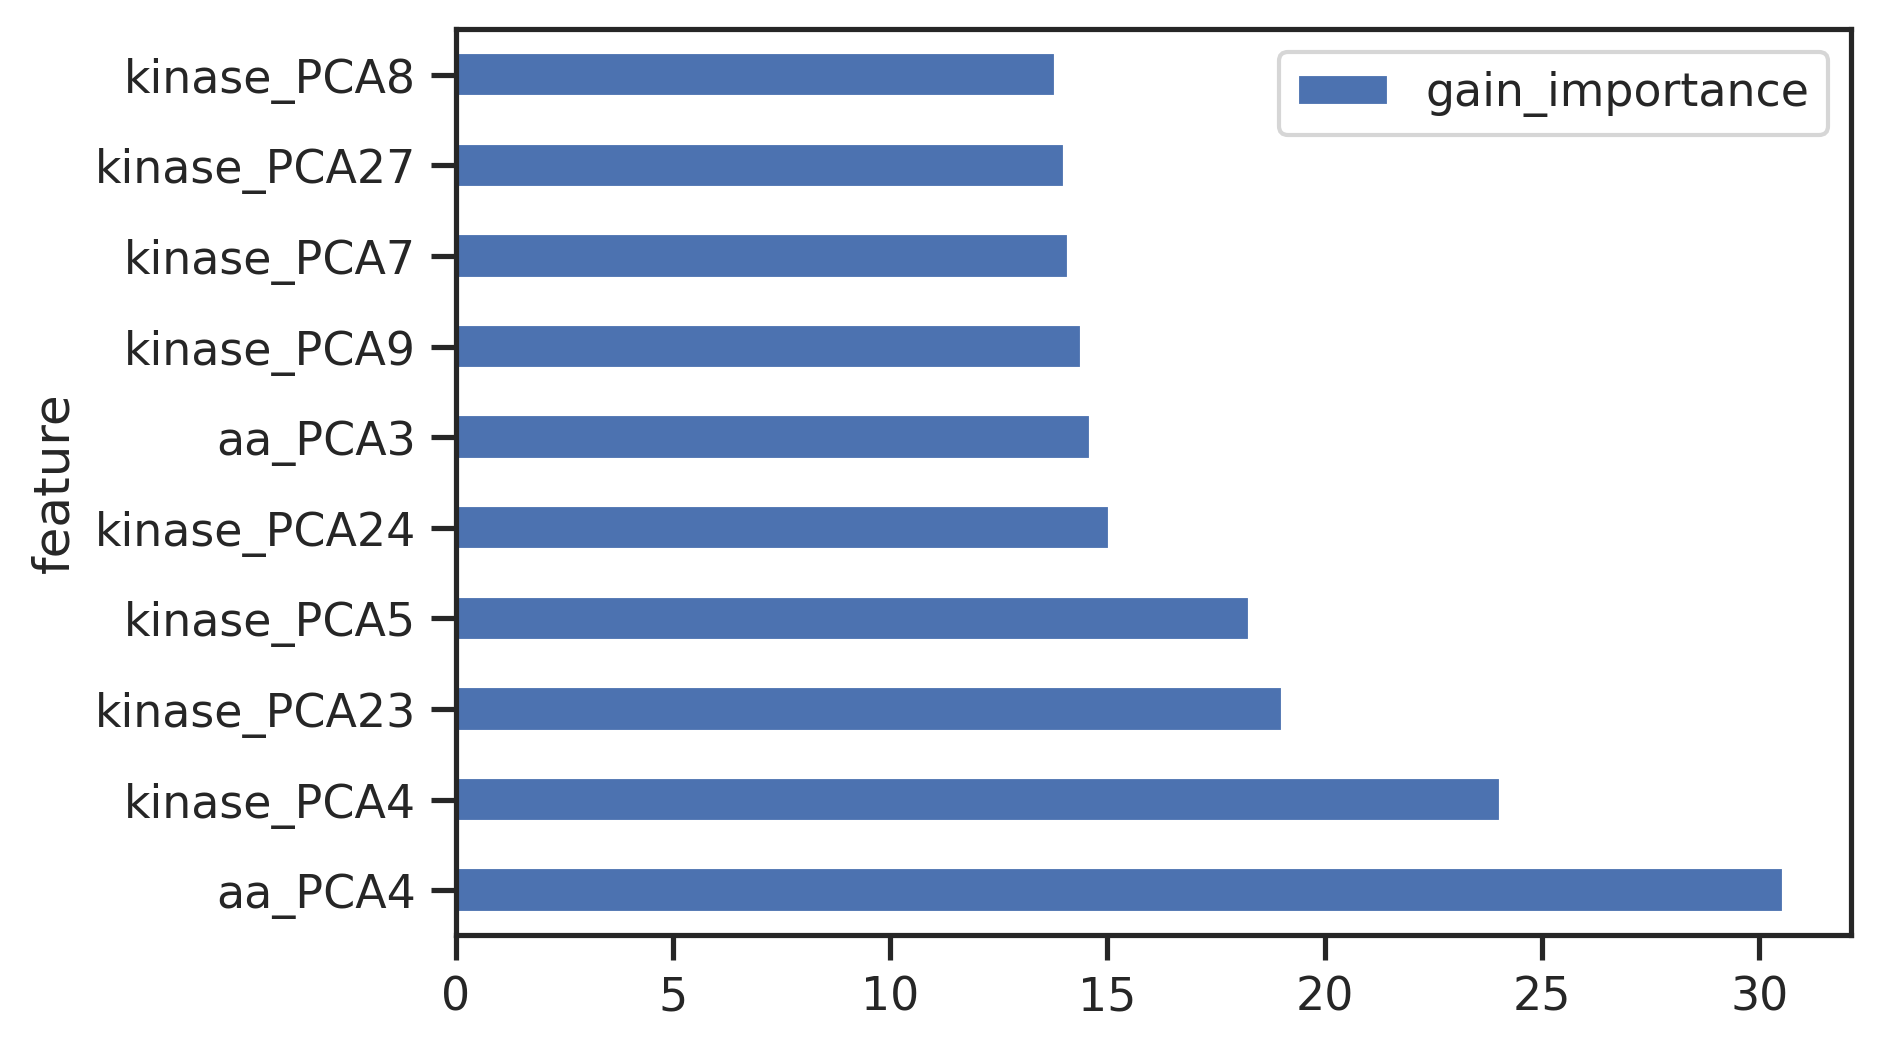

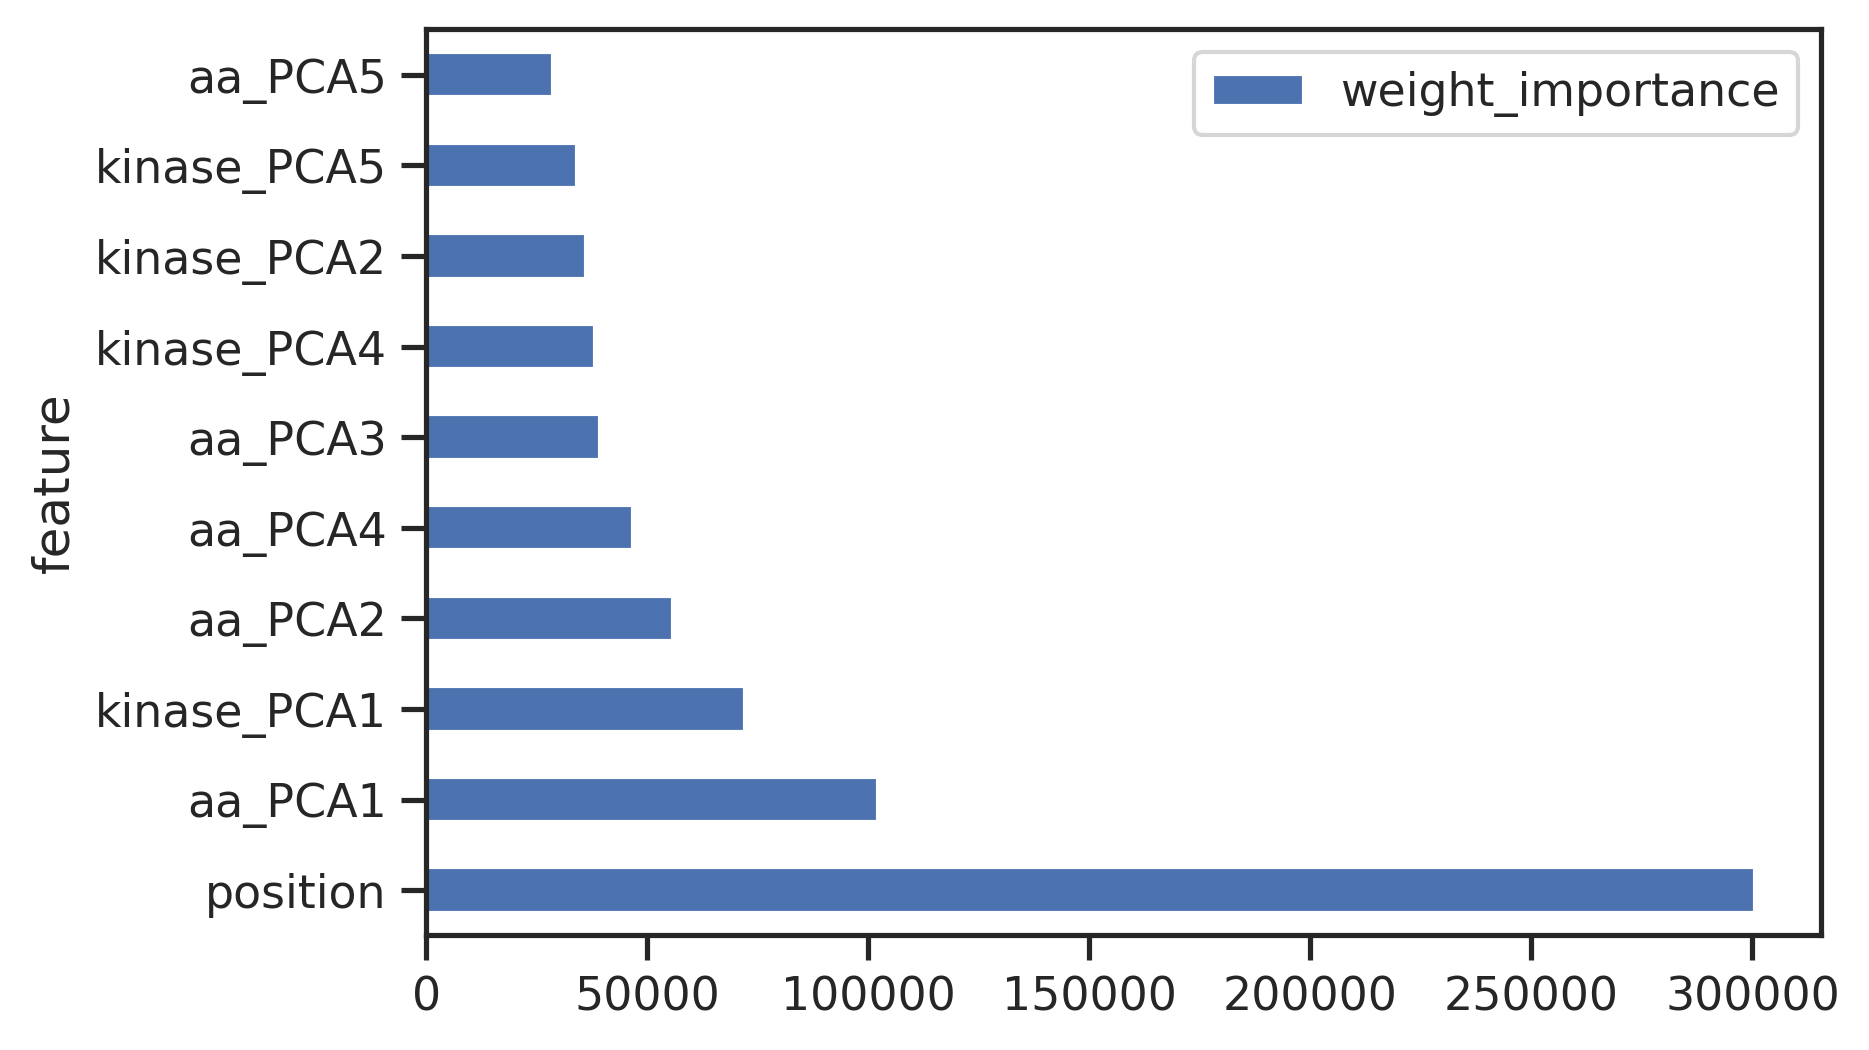

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47322, 38) (47322,) (11682, 38) (11682,)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            58994, 58995, 58996, 58997, 58998, 58999, 59000, 59001, 59002,
            59003],
           dtype='int64', length=11682)
[0]	train-rmse:1.11732	valid-rmse:1.09569
[100]	train-rmse:1.07230	valid-rmse:1.05686
[200]	train-rmse:1.03323	valid-rmse:1.02451
[300]	train-rmse:0.99937	valid-rmse:0.99774
[400]	train-rmse:0.96987	valid-rmse:0.97545
[500]	train-rmse:0.94429	valid-rmse:0.95690
[600]	train-rmse:0.92194	valid-rmse:0.94184
[700]	train-rmse:0.90250	valid-rmse:0.92931
[800]	train-rmse:0.88548	valid-rmse:0.91892
[900]	train-rmse:0.87046	valid-rmse:0.91018
[1000]	train-rmse:0.85724	valid-rmse:0.90287

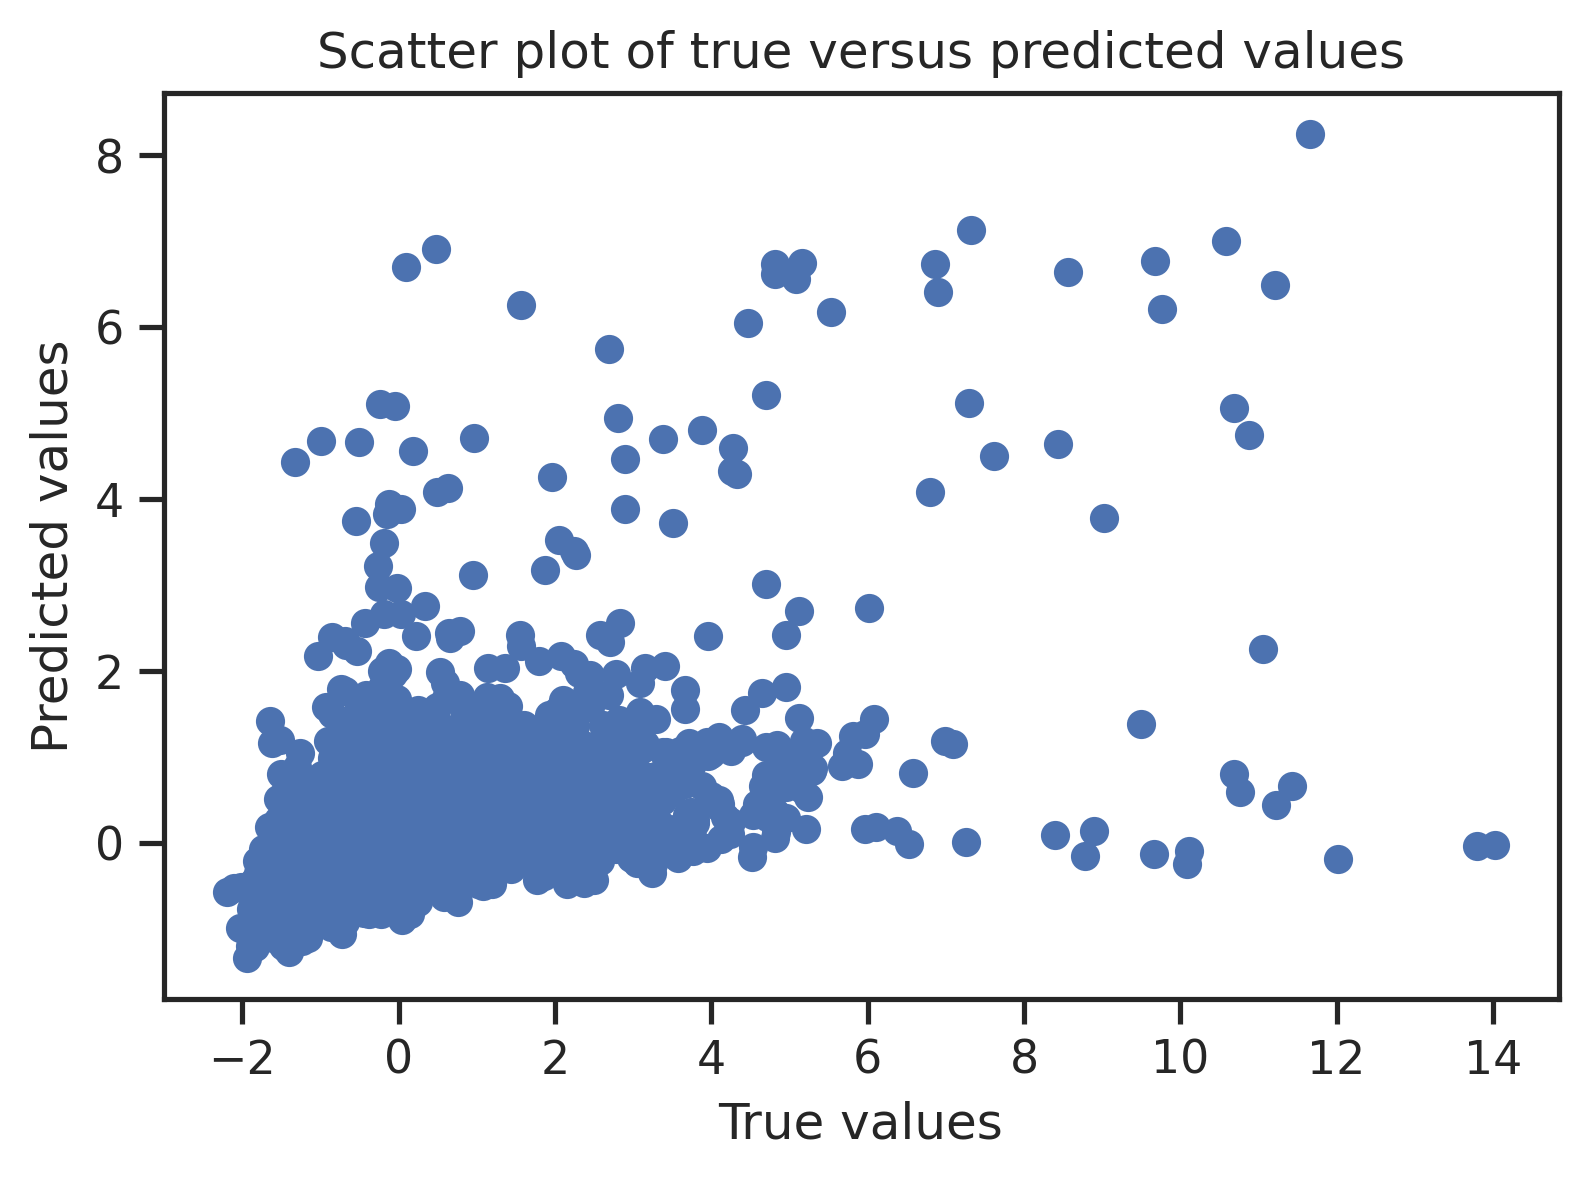

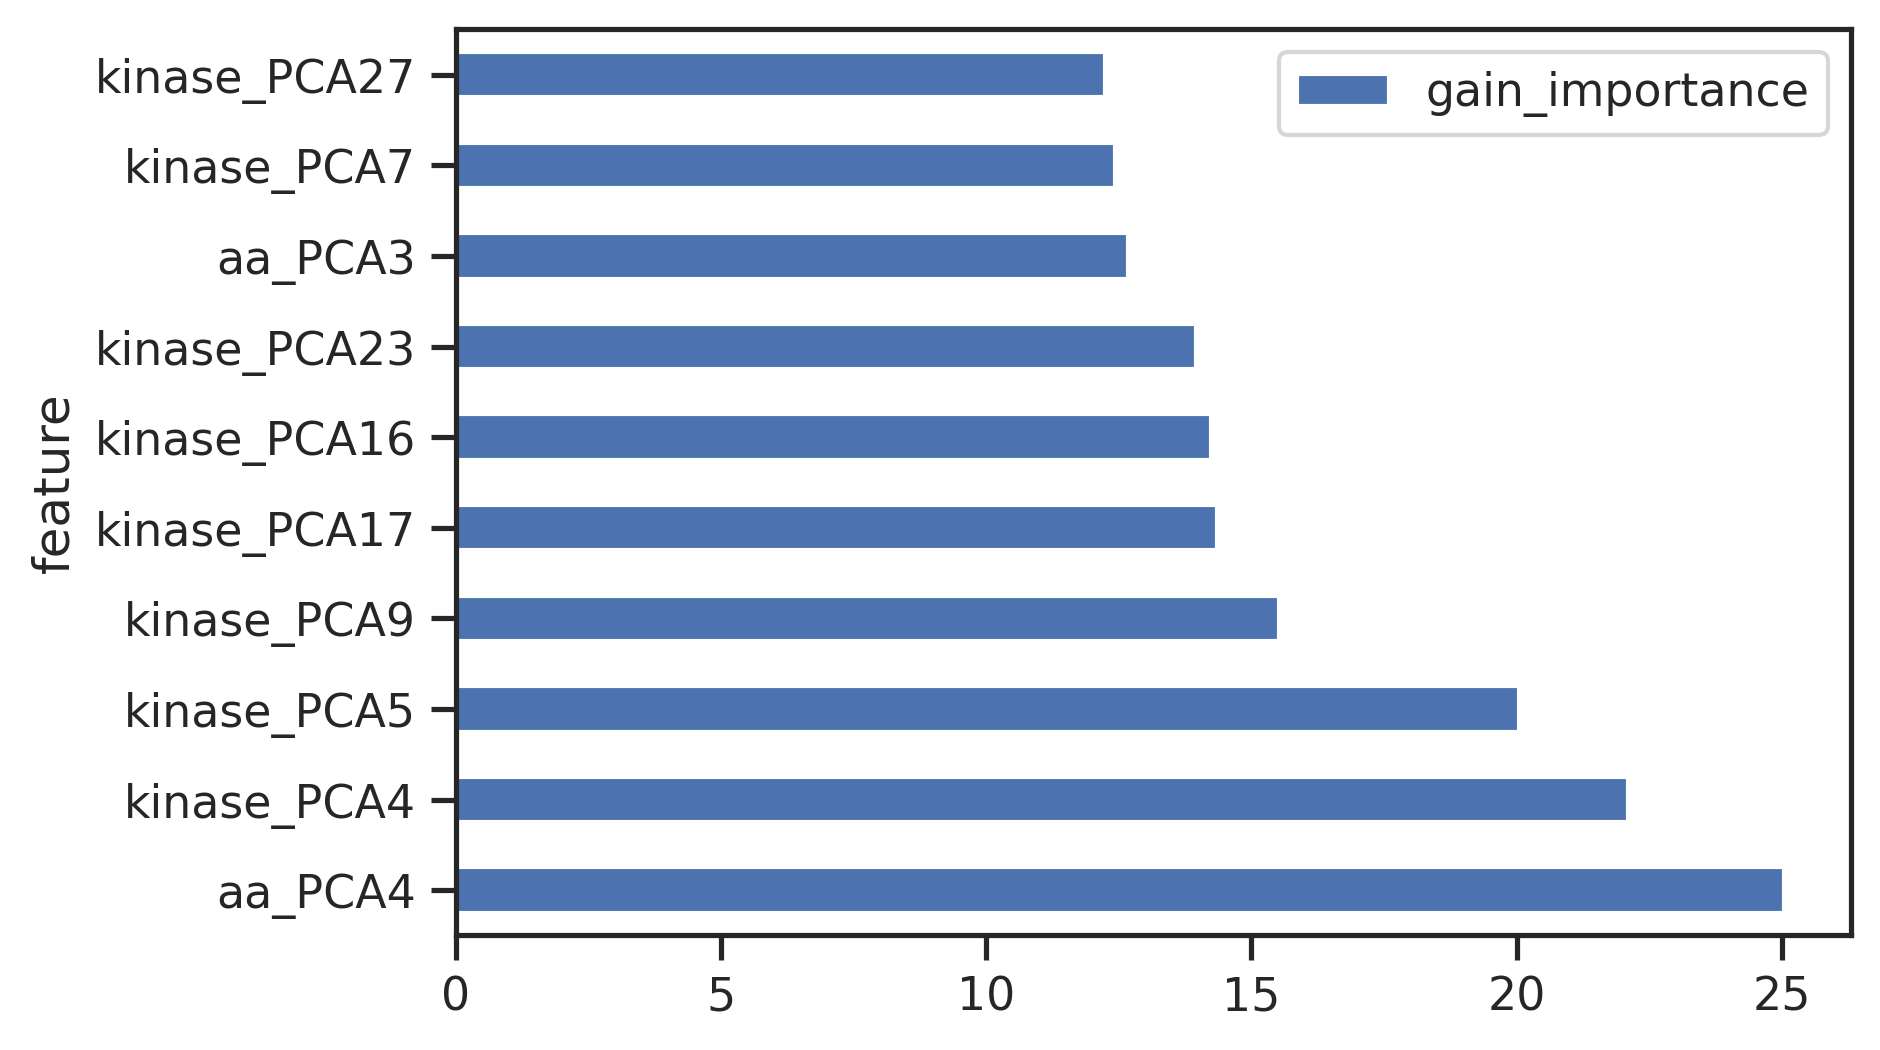

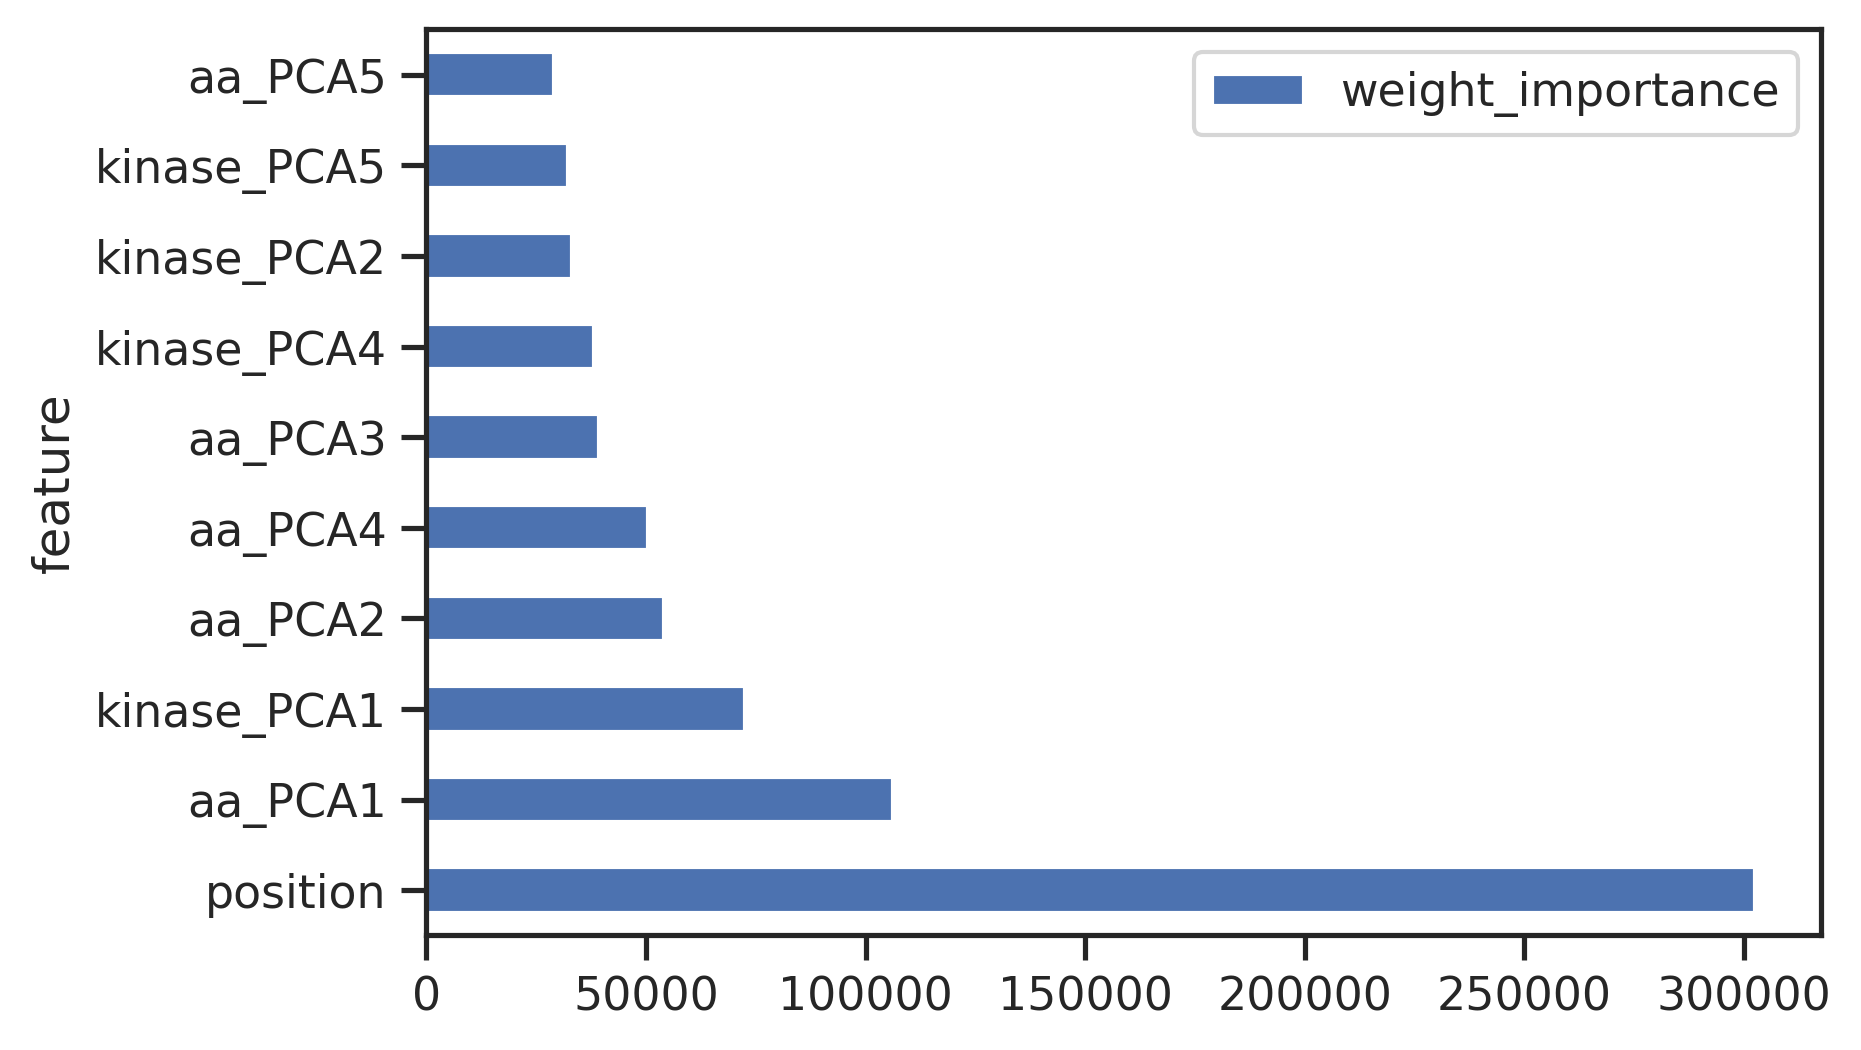

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47124, 38) (47124,) (11880, 38) (11880,)
Int64Index([  198,   199,   200,   201,   202,   203,   204,   205,   206,
              207,
            ...
            57806, 57807, 57808, 57809, 57810, 57811, 57812, 57813, 57814,
            57815],
           dtype='int64', length=11880)
[0]	train-rmse:1.11242	valid-rmse:1.11563
[100]	train-rmse:1.06862	valid-rmse:1.07390
[200]	train-rmse:1.03042	valid-rmse:1.03864
[300]	train-rmse:0.99681	valid-rmse:1.00926
[400]	train-rmse:0.96750	valid-rmse:0.98482
[500]	train-rmse:0.94212	valid-rmse:0.96436
[600]	train-rmse:0.92001	valid-rmse:0.94708
[700]	train-rmse:0.90075	valid-rmse:0.93258
[800]	train-rmse:0.88377	valid-rmse:0.92028
[900]	train-rmse:0.86871	valid-rmse:0.90969
[1000]	train-rmse:0.85510	valid-rmse:0.90027

In [ ]:
FOLDS=5
pred_dfs = []
gains = []
weights = []
for fold, (train_idx, valid_idx) in enumerate(StratifiedGroupKFold(FOLDS).split(df2.index.values, df2.category,df2.kinase)):
    pred_df, gain, weight = xgb_trainer(df, feat_col, target_col = 'target', test_index=valid_idx, model_file = f'model/fold{fold}.bin')
    pred_dfs.append(pred_df)
    gains.append(gain)
    weights.append(weight)

Save gain importance and weight importance of each fold to dataframes

In [ ]:
# gain importance
g = pd.concat(gains, axis=1, keys=range(len(gains)))

g.columns = ['gain_importance_'+ str(i) for i in range(FOLDS)]

In [ ]:
# weight importance
w = pd.concat(weights,axis=1,keys = range(len(weights)))

w.columns = ['weight_importance_'+ str(i) for i in range(FOLDS)]

In [ ]:
g.to_csv('model/gains.csv')
w.to_csv('model/weights.csv')

In [ ]:
g.head()

In [ ]:
w.head()